In [1]:
# A Template NEMS Script suitable for beginners
# Please see docs/architecture.svg for a visual diagram of this code

import logging
import pickle
from pathlib import Path
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nems0.analysis.api
import nems0.initializers
import nems0.preprocessing as preproc
import nems0.uri
from nems0 import db
from nems0 import xforms
from nems0 import recording
from nems0.fitters.api import scipy_minimize
from nems0.signal import RasterizedSignal
from nems import Model

log = logging.getLogger(__name__)

# CONFIGURATION

# figure out data and results paths:
signals_dir = Path(nems0.NEMS_PATH) / 'recordings'
modelspecs_dir = Path(nems0.NEMS_PATH) / 'modelspecs'

In [2]:
def plot_binaural_model(model, X_val, Y_val=None):
    
    # Predict the response to the stimulus spectrogram using the fitted model.
    prediction = model.predict(X_val)
    if Y_val is None:
        cc=0
        nmse=1
    else:
        cc = np.corrcoef(prediction[:, 0], Y_val[:, 0])[0, 1]
        nmse = np.std(prediction-Y_val) / np.std(Y_val)

    wc = model.layers[0].coefficients
    fir = model.layers[1].coefficients

    if len(wc.shape)>2:
        strf=wc[:,:,0] @ fir[:,:,0].T
        if wc.shape[2]>1:
            strf2=wc[:,:,1] @ fir[:,:,1].T
        else:
            strf2=strf.copy()
    elif len(fir.shape)>2:
        strf=wc @ fir[:,:,0].T
        if fir.shape[2]>1:
            strf2=wc @ fir[:,:,1].T
        else:
            strf2 = strf.copy()
    else:
        strf=wc @ fir.T
        strf2 = strf.copy()
    strf *= model.layers[2].coefficients[0]
    strf2 *= model.layers[2].coefficients[1]
    cmax=np.max([np.abs(strf).max(), np.abs(strf2).max()])

    fig=plt.figure()
    spec = fig.add_gridspec(3, 4)

    ax0 = fig.add_subplot(spec[0, :])
    ax1 = fig.add_subplot(spec[1, :])
    ax20 = fig.add_subplot(spec[2, 0])
    ax21 = fig.add_subplot(spec[2, 1])
    ax22 = fig.add_subplot(spec[2, 2:])
    
    bins=550
    b0=0
    b1=b0+bins
    fs=100
    dur=bins/fs
    chans = X_val.shape[1]
    t=np.linspace(0,dur,bins)
    _x = np.reshape(np.transpose(X_val[b0:b1,:,:],[0,2,1]),(bins,-1)).T
    ax0.imshow(_x, aspect='auto', extent=[0,dur,-0.5,chans+0.5])
    ax0.set_title(f"{model.name} cc={cc:.3f} nmse={nmse:.3f}")
    if Y_val is not None:
        ax1.plot(t,Y_val[b0:b1,0])
    ax1.plot(t,prediction[b0:b1,0])
    ax1.set_xlim(ax0.get_xlim())
    ax20.imshow(strf, origin='lower', extent=[0,strf.shape[1],-0.5,chans+0.5], clim=[-cmax, cmax])
    ax21.imshow(strf2, origin='lower', extent=[0,strf.shape[1],-0.5,chans+0.5], clim=[-cmax, cmax])

    xin = model.evaluate(input=X_val, n=len(model)-2)['_last_output']
    xrange = np.linspace(xin.min(),xin.max(),100)[:,np.newaxis]
    xout = model.layers[-1].evaluate(xrange)
    if Y_val is not None:
        ax22.plot(xin[:,0],Y_val[:,0],'.', markersize=2, color='lightgray')
    ax22.plot(xrange[:,0],xout[:,0], color='k')


In [3]:
def plot_binaural_layers(model, X_val, Y_val=None):
    x1 = model.evaluate(input=X_val, n=0)['_last_output']
    x2 = model.evaluate(input=X_val, n=1)['_last_output']
    x3 = model.evaluate(input=X_val, n=2)['_last_output']
    x4 = model.evaluate(input=X_val, n=3)['output']

    f,ax = plt.subplots(6,1, sharex=True)

    ax[0].imshow(X_val[:1000,:,0].T, aspect='auto', interpolation='none')
    ax[0].set_ylabel('stim 0')

    ax[1].imshow(X_val[:1000,:,1].T, aspect='auto', interpolation='none')
    ax[1].set_ylabel('stim 1')

    ax[2].plot(x1[:1000,:,0])
    ax[2].plot(x1[:1000,:,1], '--')
    ax[2].set_ylabel('wc1 output')

    ax[3].plot(x2[:1000,0])
    ax[3].plot(x2[:1000,1], '--')
    ax[3].set_ylabel('fir output')

    ax[4].plot(x3[:1000,:])
    ax[4].set_ylabel('wc1 output')

    ax[5].plot(x4[:1000,:])
    if Y_val is not None:
        ax[5].plot(Y_val[:1000,0])
    ax[5].set_ylabel('dexp output')

In [4]:
def simulate_binaural(X, modelspec='wc.18x2x2.b-fir.15x2x2-wc.2x1-relu.1.o.s', verbose=False):
    
    models = Model.from_keywords(modelspec)
    wc=models.layers[0].coefficients
    wc[:] = 0
    #wc[4,1,0] = 0.5
    #wc[5,1,0] = -0.5
    wc[7,0,1] = 1
    wc[8,0,1] = 0.5
    models.layers[0]['coefficients'] = wc

    fir=models.layers[1].coefficients
    fir[:] = 0
    fir[1,1,0] = 1
    fir[2,1,0] = 1
    fir[1,0,1] = 1
    fir[2,0,1] = 0.5
    models.layers[1]['coefficients'] = fir

    wc2=models.layers[2].coefficients
    wc2[:]= 0
    wc2[0] = 1
    wc2[1] = 1
    models.layers[2]['coefficients']=wc2
    
    Y = models.predict(X)
    Y = Y + np.random.randn(len(Y),1)/Y.std()*0.05
    if verbose:
        plot_binaural_model(models, X, Y_val=Y)
    
    return Y

In [5]:
batch=338
modelname="gtgram.fs100.ch18.mono-ld.pop-norm.l1-sev_wc.Nx60-fir.1x20x60-wc.60xR-lvl.R-dexp.R_tfinit.n.lr1e3.et3.es20-newtf.n.lr1e4"
# raw binaural model
#recording_uri = '/auto/data/nems_db/recordings/338/CLT041c_c6cec16ea49389fffff3880d5742bfc3a3cf4924.tgz'
recording_uri = '/auto/data/nems_db/recordings/338/CLT039c_dd50ace1b2f07b2fa485d44fa09f5908ca222e0d.tgz'
rec = recording.load_recording(recording_uri)

# "HRTF" binaural model
recording_uri = '/auto/data/nems_db/recordings/338/CLT039c_03fad55eb0b91a734d800a85ad3a78ae790c7d36.tgz'
rec_hrtf = recording.load_recording(recording_uri)

rec['stim_hrtf'] = rec_hrtf['stim']

ctx = {'rec': rec}
ctx.update(xforms.normalize_sig(sig='resp', norm_method='minmax', **ctx))
ctx.update(xforms.normalize_sig(sig='stim', norm_method='minmax', log_compress=1, **ctx))
ctx.update(xforms.normalize_sig(sig='stim_hrtf', norm_method='minmax', log_compress=1, **ctx))
ctx.update(xforms.split_by_occurrence_counts(epoch_regex='^STIM', **ctx))
ctx.update(xforms.average_away_stim_occurrences(epoch_regex='^STIM', **ctx))

[nems0.xforms INFO] xforms.normalize_sig(minmax): resp b=0.0, g=3.8181818181818183, dlog(..., -None)
[nems0.xforms INFO] xforms.normalize_sig(minmax): stim b=0.0, g=5.311554912564187, dlog(..., -1)
[nems0.xforms INFO] xforms.normalize_sig(minmax): stim_hrtf b=0.0, g=5.1749485177800185, dlog(..., -1)


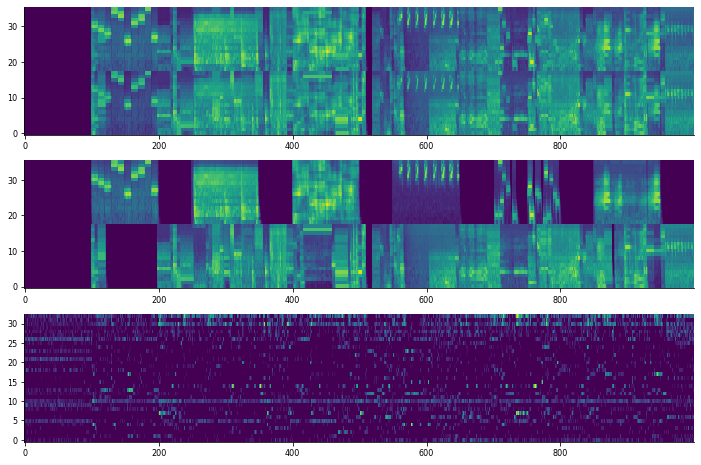

In [6]:
X_all_h = ctx['val']['stim_hrtf'].as_continuous()
X_all = ctx['val']['stim'].as_continuous()
Y_all = ctx['val']['resp'].as_continuous()
f,ax = plt.subplots(3,1, figsize=(12,8))
ax[0].imshow(X_all_h[:,:1000], aspect='auto', interpolation='none', origin='lower')
ax[1].imshow(X_all[:,:1000], aspect='auto', interpolation='none', origin='lower')
ax[2].imshow(Y_all[:,:1000], aspect='auto', interpolation='none', origin='lower')

In [12]:
# testing binaural NAT with various model architectures.
cellids = [rec['resp'].chans[6]]
cellids = [rec['resp'].chans[19]]
cellids = [rec['resp'].chans[30]]
cellids = [rec['resp'].chans[10]]
cellids = [rec['resp'].chans[4]]

print("cellids: ", cellids)

X_est_h = ctx['est']['stim_hrtf'].as_continuous().T.copy()
X_est = ctx['est']['stim'].as_continuous().T.copy()
Y_est = ctx['est']['resp'].extract_channels(cellids).as_continuous().T
X_val_h = ctx['val']['stim_hrtf'].as_continuous().T.copy()
X_val = ctx['val']['stim'].as_continuous().T.copy()
Y_val = ctx['val']['resp'].extract_channels(cellids).as_continuous().T

X_norm = X_est.max()
X_est_h /= X_norm
X_est /= X_norm
X_val_h /= X_norm
X_val /= X_norm

if True:
    # binaural STRF
    X_est_h=np.swapaxes(np.reshape(X_est_h, [-1, 2, 18]), 2, 1)
    X_est=np.swapaxes(np.reshape(X_est, [-1, 2, 18]), 2, 1)
    X_val_h=np.swapaxes(np.reshape(X_val_h, [-1, 2, 18]), 2, 1)
    X_val=np.swapaxes(np.reshape(X_val, [-1, 2, 18]), 2, 1)

    # shorten est data for speed
    #X_est_h = X_est_h[:150000, :, :]
    #X_est = X_est[:150000, :, :]
    #Y_est = Y_est[:150000, :]

    modelspec = 'wc.18x3x1.b-fir.15x3x1-wc.2x1-dexp.1'
    modelspec = 'wc.18x2x2.b-fir.15x2x2-wc.2x1-relu.1.o.s'
    modelspec = 'wc.18x2x2.b-fir.15x2x2-wc.2x1-dexp.1'
else:
    modelspec = 'wc.36x2-fir.15x2-dexp.1'

    # shorten est data for speed
    X_est_h = X_est_h[:50000, :]
    X_est = X_est[:50000, :]
    Y_est = Y_est[:50000, :]

cellids:  ['CLT039c-016-1']


In [13]:
X_est_h.shape

(396000, 18, 2)

## Simulate specific tuning

simulating response vectors


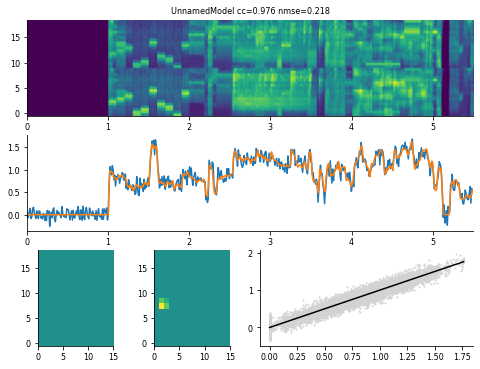

In [18]:
simulate=True
if simulate:
    print('simulating response vectors')
    Y_est = simulate_binaural(X_est_h, modelspec='wc.18x2x2.b-fir.15x2x2-wc.2x1-relu.1.o.s', verbose=False)
    Y_val = simulate_binaural(X_val_h, modelspec='wc.18x2x2.b-fir.15x2x2-wc.2x1-relu.1.o.s', verbose=True)

## Initialize model, plot initialized model

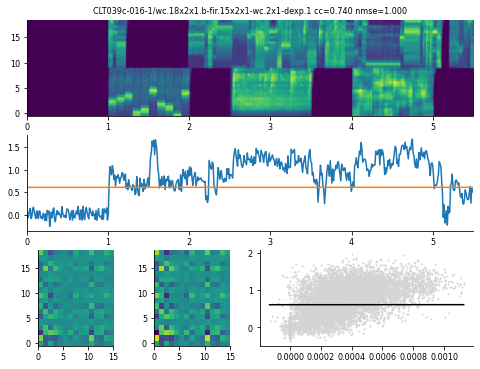

In [19]:
modelspec = 'wc.18x2x1.b-fir.15x2x1-wc.2x1-dexp.1'
model0 = Model.from_keywords(modelspec)
model0.name = f"{cellids[0]}/{modelspec}"

# Set initial values
# quick & dirty, but may not work as desired
model0 = model0.sample_from_priors()
model0 = model0.sample_from_priors()
#model0 = model0.sample_from_priors()

plot_binaural_model(model0, X_val, Y_val=Y_val)

## Fit with TF backend

In [20]:
fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 
                  'early_stopping_patience': 10,
                  'early_stopping_tolerance': 1e-3, 'validation_split': 0.0,
                  'learning_rate': 5e-3, 'epochs': 2000}

# Trying a TF fit:
model = model0.copy()
model.layers[-1].skip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est_h, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

fitter_options['early_stopping_tolerance'] = 1e-4
fitter_options['learning_rate'] = 1e-3
model.layers[-1].unskip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est_h, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

TF model built...
Model: "CLT039c-016-1/wc.18x2x1.b-fir.15x2x1-wc.2x1-dexp.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 396000, 18, 2)]   0         
                                                                 
 wc (WeightChannelsMultiTF)  (None, 396000, 2, 2)      36        
                                                                 
 fir (FiniteImpulseResponseT  (None, 396000, 2)        30        
 F)                                                              
                                                                 
 wc0 (WeightChannelsTF)      (None, 396000, 1)         2         
                                                                 
 dexp (StaticNonlinearityTF)  (None, 396000, 1)        4         
                                                                 
Total params: 72
Trainable params: 69
Non-trainable params: 3
__

[tensorflow WARNING] 5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f00a84ac280> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Epoch 1/2000
1/1 [==============================] - 0s 465ms/step - loss: 0.9680
Epoch 2/2000
1/1 [==============================] - 0s 55ms/step - loss: 0.9618
Epoch 3/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.9546
Epoch 4/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.9462
Epoch 5/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.9364
Epoch 6/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.9248
Epoch 7/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.9112
Epoch 8/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.8952
Epoch 9/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.8764
Epoch 10/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.8546
Epoch 11/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.8293
Epoch 12/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.8002
Epoch 13/2000
1/1 [=================

1/1 [==============================] - 0s 52ms/step - loss: 0.2386
Epoch 103/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.2377
Epoch 104/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.2368
Epoch 105/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.2359
Epoch 106/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.2351
Epoch 107/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.2342
Epoch 108/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.2333
Epoch 109/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.2324
Epoch 110/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.2315
Epoch 111/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.2306
Epoch 112/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.2297
Epoch 113/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.2288
Epoch 114/2000
1/1 [===========

1/1 [==============================] - 0s 52ms/step - loss: 0.1740
Epoch 203/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.1737
Epoch 204/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1733
Epoch 205/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1730
Epoch 206/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1727
Epoch 207/2000
1/1 [==============================] - 0s 45ms/step - loss: 0.1723
Epoch 208/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1720
Epoch 209/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1716
Epoch 210/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.1713
Epoch 211/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1710
Epoch 212/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1707
Epoch 213/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1703
Epoch 214/2000
1/1 [===========

1/1 [==============================] - 0s 51ms/step - loss: 0.1513
Epoch 303/2000
1/1 [==============================] - 0s 46ms/step - loss: 0.1511
Epoch 304/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1510
Epoch 305/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.1509
Epoch 306/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1507
Epoch 307/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1506
Epoch 308/2000
1/1 [==============================] - 0s 46ms/step - loss: 0.1505
Epoch 309/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1503
Epoch 310/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.1502
Epoch 311/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.1501
Epoch 312/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1499
Epoch 313/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.1498
Epoch 314/2000
1/1 [===========

[tensorflow WARNING] 6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f00a83790d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


Epoch 1/2000
1/1 [==============================] - 0s 475ms/step - loss: 0.5570
Epoch 2/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.5511
Epoch 3/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.5451
Epoch 4/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.5390
Epoch 5/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.5329
Epoch 6/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.5267
Epoch 7/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.5205
Epoch 8/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.5142
Epoch 9/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.5080
Epoch 10/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.5017
Epoch 11/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.4954
Epoch 12/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.4891
Epoch 13/2000
1/1 [=================

1/1 [==============================] - 0s 49ms/step - loss: 0.3288
Epoch 103/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.3279
Epoch 104/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.3270
Epoch 105/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.3261
Epoch 106/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.3252
Epoch 107/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.3243
Epoch 108/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.3234
Epoch 109/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.3225
Epoch 110/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.3216
Epoch 111/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.3207
Epoch 112/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.3198
Epoch 113/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.3189
Epoch 114/2000
1/1 [===========

1/1 [==============================] - 0s 47ms/step - loss: 0.2514
Epoch 203/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.2508
Epoch 204/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.2502
Epoch 205/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.2496
Epoch 206/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.2490
Epoch 207/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.2484
Epoch 208/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.2478
Epoch 209/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.2472
Epoch 210/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.2466
Epoch 211/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.2461
Epoch 212/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.2455
Epoch 213/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.2449
Epoch 214/2000
1/1 [===========

1/1 [==============================] - 0s 52ms/step - loss: 0.2031
Epoch 303/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.2027
Epoch 304/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.2023
Epoch 305/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.2020
Epoch 306/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.2016
Epoch 307/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.2012
Epoch 308/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.2009
Epoch 309/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.2005
Epoch 310/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.2001
Epoch 311/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.1998
Epoch 312/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.1994
Epoch 313/2000
1/1 [==============================] - 0s 54ms/step - loss: 0.1991
Epoch 314/2000
1/1 [===========

1/1 [==============================] - 0s 52ms/step - loss: 0.1742
Epoch 403/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1740
Epoch 404/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1738
Epoch 405/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.1736
Epoch 406/2000
1/1 [==============================] - 0s 54ms/step - loss: 0.1734
Epoch 407/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1732
Epoch 408/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.1730
Epoch 409/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.1728
Epoch 410/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1726
Epoch 411/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.1724
Epoch 412/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1722
Epoch 413/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1720
Epoch 414/2000
1/1 [===========

1/1 [==============================] - 0s 53ms/step - loss: 0.1585
Epoch 503/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1584
Epoch 504/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1582
Epoch 505/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1581
Epoch 506/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1580
Epoch 507/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1579
Epoch 508/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1578
Epoch 509/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1577
Epoch 510/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.1575
Epoch 511/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1574
Epoch 512/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.1573
Epoch 513/2000
1/1 [==============================] - 0s 54ms/step - loss: 0.1572
Epoch 514/2000
1/1 [===========

1/1 [==============================] - 0s 50ms/step - loss: 0.1492
Epoch 603/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.1491
Epoch 604/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1491
Epoch 605/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1490
Epoch 606/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.1489
Epoch 607/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1489
Epoch 608/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.1488
Epoch 609/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.1487
Epoch 610/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1487
Epoch 611/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1486
Epoch 612/2000
1/1 [==============================] - 0s 47ms/step - loss: 0.1485
Epoch 613/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.1485
Epoch 614/2000
1/1 [===========

1/1 [==============================] - 0s 53ms/step - loss: 0.1442
Epoch 703/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1441
Epoch 704/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.1441
Epoch 705/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.1440
Epoch 706/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1440
Epoch 707/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.1440
Epoch 708/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1439
Epoch 709/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1439
Epoch 710/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1439
Epoch 711/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.1438
Epoch 712/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1438
Epoch 713/2000
1/1 [==============================] - 0s 46ms/step - loss: 0.1438
Epoch 714/2000
1/1 [===========

1/1 [==============================] - 0s 53ms/step - loss: 0.1413
Epoch 803/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1413
Epoch 804/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1412
Epoch 805/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1412
Epoch 806/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1412
Epoch 807/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1412
Epoch 808/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1412
Epoch 809/2000
1/1 [==============================] - 0s 49ms/step - loss: 0.1411
Epoch 810/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.1411
Epoch 811/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.1411
Epoch 812/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1411
Epoch 813/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1410
Epoch 814/2000
1/1 [===========

1/1 [==============================] - 0s 52ms/step - loss: 0.1394
Epoch 903/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.1394
Epoch 904/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1393
Epoch 905/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1393
Epoch 906/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1393
Epoch 907/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1393
Epoch 908/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.1393
Epoch 909/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1393
Epoch 910/2000
1/1 [==============================] - 0s 50ms/step - loss: 0.1393
Epoch 911/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1392
Epoch 912/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1392
Epoch 913/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1392
Epoch 914/2000
1/1 [===========

Epoch 1002/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1380
Epoch 1003/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.1379
Epoch 1004/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1379
Epoch 1005/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1379
Epoch 1006/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1379
Epoch 1007/2000
1/1 [==============================] - 0s 48ms/step - loss: 0.1379
Epoch 1008/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1379
Epoch 1009/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1379
Epoch 1010/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1379
Epoch 1011/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1379
Epoch 1012/2000
1/1 [==============================] - 0s 52ms/step - loss: 0.1378
Epoch 1013/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1378
Epoc

1/1 [==============================] - 0s 48ms/step - loss: 0.1369
Epoch 1101/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1369
Epoch 1102/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1369
Epoch 1103/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1368
Epoch 1104/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1368
Epoch 1105/2000
1/1 [==============================] - 0s 46ms/step - loss: 0.1368
Epoch 1106/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1368
Epoch 1107/2000
1/1 [==============================] - 0s 51ms/step - loss: 0.1368
Epoch 1108/2000
1/1 [==============================] - 0s 53ms/step - loss: 0.1368
Epoch 01108: early stopping


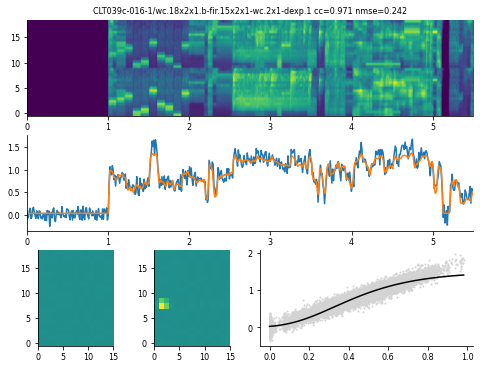

In [21]:
plot_binaural_model(model, X_val_h, Y_val=Y_val)

In [24]:
model.layers[0].coefficients[:,:,0]

array([[ 1.13782408e-02,  8.91905371e-03],
       [ 7.83610642e-02, -6.38536215e-02],
       [-1.03124812e-01,  9.17834342e-02],
       [ 7.58306356e-03,  4.33162879e-03],
       [-1.47493766e-03, -5.23210922e-03],
       [-9.18502584e-02,  3.83814834e-02],
       [-6.11644378e-03,  3.18959402e-03],
       [ 9.15213406e-01,  8.12247157e-01],
       [ 4.70096409e-01,  4.26342815e-01],
       [ 5.46733402e-02, -7.31061772e-02],
       [-1.31379580e-02, -1.14561170e-02],
       [ 2.90159788e-03, -3.39939147e-02],
       [-3.66584398e-02,  3.69657986e-02],
       [-1.90462228e-02,  1.04283337e-02],
       [-1.43089844e-02,  2.01306306e-02],
       [-5.59135638e-02,  4.00736518e-02],
       [ 3.92229922e-05, -1.22641306e-02],
       [ 9.82830450e-02, -4.05149907e-02]])

## Fit with scipy backend

In [100]:
print('Fitting without NL ...')
model_sci = model0.copy()

model_sci.layers[-1].skip_nonlinearity()
model_sci = model_sci.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'ftol': 0.0001, 'maxiter': 50}})

print('Now fitting with NL ...')
model_sci.layers[-1].unskip_nonlinearity()
model_sci = model.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'ftol': 0.00001, 'maxiter': 100}})

Fitting without NL ...
Epoch 0
        Iteration 0, error is: 1.18191916...
Fit successful: True
Status: 0
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Now fitting with NL ...
Epoch 0
        Iteration 0, error is: 0.91764567...
        Iteration 5, error is: 0.91680986...
        Iteration 10, error is: 0.91513237...
        Iteration 15, error is: 0.91457561...
        Iteration 20, error is: 0.91210197...
        Iteration 25, error is: 0.91156625...
        Iteration 30, error is: 0.91078157...
        Iteration 35, error is: 0.91006482...
        Iteration 40, error is: 0.90903038...
        Iteration 45, error is: 0.90855759...
Fit successful: True
Status: 0
Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


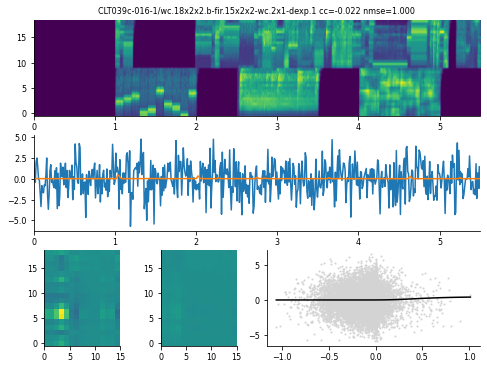

In [187]:
plot_binaural_model(model_sci, X_val, Y_val=Y_val)

Now reinitialize and fit again

In [80]:
model = Model.from_keywords(modelspec)
model = model.sample_from_priors();


In [81]:
fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 'early_stopping_patience': 10,
              'early_stopping_tolerance': 1e-3, 'validation_split': 0.0,
              'learning_rate': 5e-3, 'epochs': 2000}

# Trying a TF fit:
model.layers[-1].skip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

model.layers[-1].unskip_nonlinearity()
model = model.fit(input=np.expand_dims(X_est, axis=0),
          target=np.expand_dims(Y_est, axis=0), backend='tf',
          fitter_options=fitter_options,
          batch_size=None)

TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50000, 18, 2)]    0         
                                                                 
 wc (WeightChannelsMultiTF)  (None, 50000, 2, 2)       72        
                                                                 
 fir (FiniteImpulseResponseT  (None, 50000, 2)         60        
 F)                                                              
                                                                 
 wc0 (WeightChannelsTF)      (None, 50000, 1)          2         
                                                                 
 dexp (StaticNonlinearityTF)  (None, 50000, 1)         4         
                                                                 
Total params: 138
Trainable params: 135
Non-trainable params: 3
______________________________________

1/1 [==============================] - 0s 13ms/step - loss: 0.9977
Epoch 61/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9960
Epoch 62/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.9947
Epoch 63/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9937
Epoch 64/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9931
Epoch 65/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9927
Epoch 66/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9924
Epoch 67/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9922
Epoch 68/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9919
Epoch 69/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9917
Epoch 70/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9913
Epoch 71/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.9909
Epoch 72/2000
1/1 [=======================

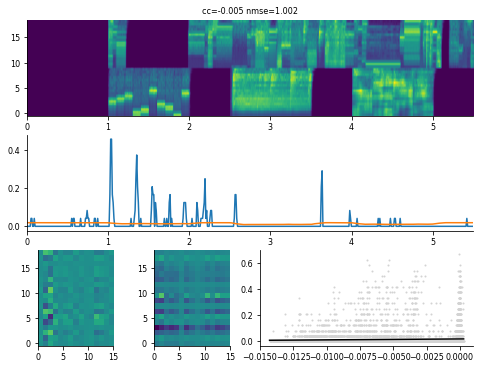

In [82]:
plot_binaural_model(model, X_val, Y_val=Y_val)

In [17]:
x1=model.predict(X_est)
x1.shape

(50000, 1)

In [18]:
x2=model.backend.predict(np.expand_dims(X_est, axis=0))[0,:,:]
x2.shape

(50000, 1)

In [13]:
np.corrcoef(x1[:,0],x2[:,0])

array([[1.        , 0.99982959],
       [0.99982959, 1.        ]])

In [19]:
np.corrcoef(x1[:,0],Y_est[:,0])

array([[ 1.        , -0.29751566],
       [-0.29751566,  1.        ]])

In [17]:
reps=15
cc=np.zeros(reps)
nmse=np.zeros(reps)

for i in range(reps):
    model = Model.from_keywords(modelspec)
    model = model.sample_from_priors();
    fitter_options = {'cost_function': 'nmse', 'early_stopping_delay': 100, 'early_stopping_patience': 10,
              'early_stopping_tolerance': 1e-3, 'validation_split': 0.0,
              'learning_rate': 5e-3, 'epochs': 2000}

    # Trying a TF fit:
    model.layers[-1].skip_nonlinearity()
    model = model.fit(input=np.expand_dims(X_est, axis=0),
              target=np.expand_dims(Y_est, axis=0), backend='tf',
              fitter_options=fitter_options,
              batch_size=None)

    model.layers[-1].unskip_nonlinearity()
    model = model.fit(input=np.expand_dims(X_est, axis=0),
              target=np.expand_dims(Y_est, axis=0), backend='tf',
              fitter_options=fitter_options,
              batch_size=None)
    
    # Predict the response to the stimulus spectrogram using the fitted model.
    prediction = model.predict(X_val)
    cc[i] = np.corrcoef(prediction[:, 0], Y_val[:, 0])[0, 1]
    nmse[i] = np.std(prediction-Y_val) / np.std(Y_val)
        

TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50000, 18, 2)]    0         
                                                                 
 wc (WeightChannelsMultiTF)  (None, 50000, 2, 2)       72        
                                                                 
 fir (FiniteImpulseResponseT  (None, 50000, 2)         60        
 F)                                                              
                                                                 
 wc0 (WeightChannelsTF)      (None, 50000, 1)          2         
                                                                 
 relu (StaticNonlinearityTF)  (None, 50000, 1)         3         
                                                                 
Total params: 137
Trainable params: 135
Non-trainable params: 2
______________________________________

1/1 [==============================] - 0s 13ms/step - loss: 0.8398
Epoch 61/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8396
Epoch 62/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8396
Epoch 63/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 64/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 65/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 66/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 67/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 68/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8394
Epoch 69/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8394
Epoch 70/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8393
Epoch 71/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8393
Epoch 72/2000
1/1 [=======================

Epoch 69/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 70/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8099
Epoch 71/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 72/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 73/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 74/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 75/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8096
Epoch 76/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 77/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 78/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8095
Epoch 79/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8095
Epoch 80/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8094
Epoch 81/2000
1/1 [=========

1/1 [==============================] - 0s 13ms/step - loss: 0.8178
Epoch 142/2000
1/1 [==============================] - 0s 21ms/step - loss: 0.8177
Epoch 143/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8176
Epoch 144/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8174
Epoch 145/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8173
Epoch 146/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8172
Epoch 147/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8170
Epoch 148/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8169
Epoch 149/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8167
Epoch 150/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8166
Epoch 151/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.8164
Epoch 152/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8162
Epoch 153/2000
1/1 [===========

1/1 [==============================] - 0s 13ms/step - loss: 0.8618
Epoch 23/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8578
Epoch 24/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8538
Epoch 25/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8501
Epoch 26/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8469
Epoch 27/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8445
Epoch 28/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8428
Epoch 29/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8418
Epoch 30/2000
1/1 [==============================] - 0s 20ms/step - loss: 0.8415
Epoch 31/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8418
Epoch 32/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8423
Epoch 33/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8431
Epoch 34/2000
1/1 [=======================

1/1 [==============================] - 0s 15ms/step - loss: 0.8235
Epoch 124/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8229
Epoch 125/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8223
Epoch 126/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8217
Epoch 127/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8212
Epoch 128/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8208
Epoch 129/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8203
Epoch 130/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8199
Epoch 131/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8196
Epoch 132/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8193
Epoch 133/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8190
Epoch 134/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8188
Epoch 135/2000
1/1 [===========

Epoch 4/2000
1/1 [==============================] - 0s 13ms/step - loss: 1.0406
Epoch 5/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.0005
Epoch 6/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.9617
Epoch 7/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.9273
Epoch 8/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8993
Epoch 9/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8786
Epoch 10/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8650
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8577
Epoch 12/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8555
Epoch 13/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8569
Epoch 14/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8602
Epoch 15/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8641
Epoch 16/2000
1/1 [===============

1/1 [==============================] - 0s 15ms/step - loss: 0.8338
Epoch 106/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8334
Epoch 107/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8330
Epoch 108/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8326
Epoch 109/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8321
Epoch 110/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8316
Epoch 111/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8311
Epoch 112/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8306
Epoch 113/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8300
Epoch 114/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8294
Epoch 115/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8288
Epoch 116/2000
1/1 [==============================] - 0s 16ms/step - loss: 0.8281
Epoch 117/2000
1/1 [===========

Epoch 00112: early stopping
TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50000, 18, 2)]    0         
                                                                 
 wc (WeightChannelsMultiTF)  (None, 50000, 2, 2)       72        
                                                                 
 fir (FiniteImpulseResponseT  (None, 50000, 2)         60        
 F)                                                              
                                                                 
 wc0 (WeightChannelsTF)      (None, 50000, 1)          2         
                                                                 
 relu (RectifiedLinearTF)    (None, 50000, 1)          3         
                                                                 
Total params: 137
Trainable params: 136
Non-trainable params: 1
__________

1/1 [==============================] - 0s 294ms/step - loss: 0.8773
Epoch 2/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8688
Epoch 3/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8614
Epoch 4/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8550
Epoch 5/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8496
Epoch 6/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8453
Epoch 7/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8421
Epoch 8/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8398
Epoch 9/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8384
Epoch 10/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8378
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8377
Epoch 12/2000
1/1 [==============================] - 0s 18ms/step - loss: 0.8380
Epoch 13/2000
1/1 [==============================

1/1 [==============================] - 0s 14ms/step - loss: 0.8389
Epoch 76/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8388
Epoch 77/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8388
Epoch 78/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8387
Epoch 79/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8386
Epoch 80/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8385
Epoch 81/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8385
Epoch 82/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8384
Epoch 83/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8383
Epoch 84/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8382
Epoch 85/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8381
Epoch 86/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8380
Epoch 87/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8092
Epoch 85/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8092
Epoch 86/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8092
Epoch 87/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8091
Epoch 88/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8091
Epoch 89/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8091
Epoch 90/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8090
Epoch 91/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8090
Epoch 92/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8090
Epoch 93/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8090
Epoch 94/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8089
Epoch 95/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8089
Epoch 96/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8403
Epoch 58/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8401
Epoch 59/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8399
Epoch 60/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8398
Epoch 61/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8396
Epoch 62/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8396
Epoch 63/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 64/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 65/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 66/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 67/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 68/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8394
Epoch 69/2000
1/1 [=======================

Epoch 66/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8102
Epoch 67/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8101
Epoch 68/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 69/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 70/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8099
Epoch 71/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 72/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 73/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 74/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 75/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 76/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8096
Epoch 77/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 78/2000
1/1 [=========

1/1 [==============================] - 0s 14ms/step - loss: 0.8181
Epoch 139/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8180
Epoch 140/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8179
Epoch 141/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8178
Epoch 142/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8177
Epoch 143/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8176
Epoch 144/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8174
Epoch 145/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8173
Epoch 146/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8172
Epoch 147/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8170
Epoch 148/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8169
Epoch 149/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8167
Epoch 150/2000
1/1 [===========

1/1 [==============================] - 0s 13ms/step - loss: 0.8704
Epoch 20/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8685
Epoch 21/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8655
Epoch 22/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8618
Epoch 23/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8578
Epoch 24/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8538
Epoch 25/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8501
Epoch 26/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8469
Epoch 27/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8445
Epoch 28/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8428
Epoch 29/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8418
Epoch 30/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8415
Epoch 31/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8255
Epoch 121/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8248
Epoch 122/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8242
Epoch 123/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8235
Epoch 124/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8229
Epoch 125/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8223
Epoch 126/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8217
Epoch 127/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8212
Epoch 128/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8208
Epoch 129/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8203
Epoch 130/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8199
Epoch 131/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8196
Epoch 132/2000
1/1 [===========

Epoch 1/2000
1/1 [==============================] - 0s 322ms/step - loss: 1.1471
Epoch 2/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.1152
Epoch 3/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.0794
Epoch 4/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.0406
Epoch 5/2000
1/1 [==============================] - 0s 11ms/step - loss: 1.0005
Epoch 6/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.9617
Epoch 7/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.9273
Epoch 8/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8993
Epoch 9/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8786
Epoch 10/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8650
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8577
Epoch 12/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8555
Epoch 13/2000
1/1 [=================

1/1 [==============================] - 0s 11ms/step - loss: 0.8378
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8377
Epoch 12/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8380
Epoch 13/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8385
Epoch 14/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8390
Epoch 15/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8393
Epoch 16/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8393
Epoch 17/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8390
Epoch 18/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8383
Epoch 19/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8371
Epoch 20/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8355
Epoch 21/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8336
Epoch 22/2000
1/1 [=======================

1/1 [==============================] - 0s 12ms/step - loss: 0.8086
Epoch 112/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8086
Epoch 00112: early stopping
TF model built...
Model: "UnnamedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 50000, 18, 2)]    0         
                                                                 
 wc (WeightChannelsMultiTF)  (None, 50000, 2, 2)       72        
                                                                 
 fir (FiniteImpulseResponseT  (None, 50000, 2)         60        
 F)                                                              
                                                                 
 wc0 (WeightChannelsTF)      (None, 50000, 1)          2         
                                                                 
 relu (RectifiedLinearTF)    (None, 50000, 1)          3 

1/1 [==============================] - 0s 12ms/step - loss: 0.8382
Epoch 85/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8381
Epoch 86/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8380
Epoch 87/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8379
Epoch 88/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8377
Epoch 89/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8376
Epoch 90/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8374
Epoch 91/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8373
Epoch 92/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8371
Epoch 93/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8370
Epoch 94/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8368
Epoch 95/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8366
Epoch 96/2000
1/1 [=======================

1/1 [==============================] - 0s 294ms/step - loss: 0.8773
Epoch 2/2000
1/1 [==============================] - 0s 9ms/step - loss: 0.8688
Epoch 3/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8614
Epoch 4/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8550
Epoch 5/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8496
Epoch 6/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8453
Epoch 7/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8421
Epoch 8/2000
1/1 [==============================] - 0s 10ms/step - loss: 0.8398
Epoch 9/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8384
Epoch 10/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8378
Epoch 11/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8377
Epoch 12/2000
1/1 [==============================] - 0s 11ms/step - loss: 0.8380
Epoch 13/2000
1/1 [==============================]

1/1 [==============================] - 0s 12ms/step - loss: 0.8389
Epoch 76/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8388
Epoch 77/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8388
Epoch 78/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8387
Epoch 79/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8386
Epoch 80/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8385
Epoch 81/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8385
Epoch 82/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8384
Epoch 83/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8383
Epoch 84/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8382
Epoch 85/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8381
Epoch 86/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8380
Epoch 87/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8092
Epoch 85/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8092
Epoch 86/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8092
Epoch 87/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8091
Epoch 88/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8091
Epoch 89/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8091
Epoch 90/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8090
Epoch 91/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8090
Epoch 92/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8090
Epoch 93/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8090
Epoch 94/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8089
Epoch 95/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8089
Epoch 96/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8403
Epoch 58/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8401
Epoch 59/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8399
Epoch 60/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8398
Epoch 61/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8396
Epoch 62/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8396
Epoch 63/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8395
Epoch 64/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8395
Epoch 65/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 66/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 67/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8395
Epoch 68/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8394
Epoch 69/2000
1/1 [=======================

Epoch 66/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8102
Epoch 67/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8101
Epoch 68/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 69/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8100
Epoch 70/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8099
Epoch 71/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 72/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8098
Epoch 73/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 74/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8097
Epoch 75/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 76/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 77/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8096
Epoch 78/2000
1/1 [=========

1/1 [==============================] - 0s 12ms/step - loss: 0.8181
Epoch 139/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8180
Epoch 140/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8179
Epoch 141/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8178
Epoch 142/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8177
Epoch 143/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8176
Epoch 144/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8174
Epoch 145/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8173
Epoch 146/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8172
Epoch 147/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8170
Epoch 148/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8169
Epoch 149/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8167
Epoch 150/2000
1/1 [===========

1/1 [==============================] - 0s 12ms/step - loss: 0.8704
Epoch 20/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8685
Epoch 21/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8655
Epoch 22/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8618
Epoch 23/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8578
Epoch 24/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8538
Epoch 25/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8501
Epoch 26/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8469
Epoch 27/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8445
Epoch 28/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8428
Epoch 29/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8418
Epoch 30/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8415
Epoch 31/2000
1/1 [=======================

1/1 [==============================] - 0s 13ms/step - loss: 0.8255
Epoch 121/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8248
Epoch 122/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8242
Epoch 123/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8235
Epoch 124/2000
1/1 [==============================] - 0s 13ms/step - loss: 0.8229
Epoch 125/2000
1/1 [==============================] - 0s 14ms/step - loss: 0.8223
Epoch 126/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8217
Epoch 127/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8212
Epoch 128/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8208
Epoch 129/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8203
Epoch 130/2000
1/1 [==============================] - 0s 15ms/step - loss: 0.8199
Epoch 131/2000
1/1 [==============================] - 0s 12ms/step - loss: 0.8196
Epoch 132/2000
1/1 [===========

In [18]:
cc,nmse

(array([0.50333618, 0.50333621, 0.50333622, 0.5033362 , 0.5033362 ,
        0.50333617, 0.50333622, 0.50333621, 0.50333621, 0.50333622,
        0.50333617, 0.50333619, 0.50333618, 0.50333621, 0.5033362 ]),
 array([0.86485837, 0.86485836, 0.86485835, 0.86485836, 0.86485836,
        0.86485838, 0.86485835, 0.86485836, 0.86485836, 0.86485835,
        0.86485837, 0.86485837, 0.86485837, 0.86485836, 0.86485836]))

In [19]:
!hostname

manatee


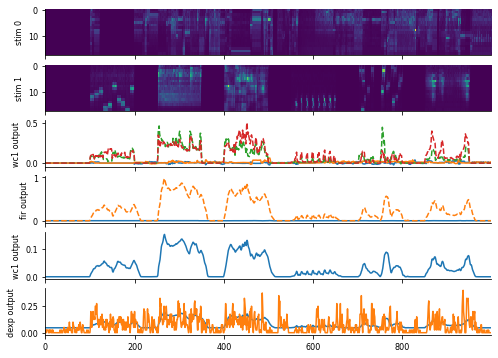

In [21]:
plot_binaural_layers(model, X_val, Y_val=Y_val)

Fit with scipy backend

In [ ]:
print('Fitting without NL ...')
model.layers[-1].skip_nonlinearity()
model = model.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'ftol': 0.00000001, 'maxiter': 50}})

print('Now fitting with NL ...')
model.layers[-1].unskip_nonlinearity()
model = model.fit(input=X_est, target=Y_est, backend='scipy',
          fitter_options={'cost_function': 'nmse', 'options': {'ftol': 0.000000001, 'maxiter': 100}})

Fitting without NL ...
Epoch 0
        Iteration 0, error is: 1.00072953...


Test that model does what it's supposed to do with each coefficient

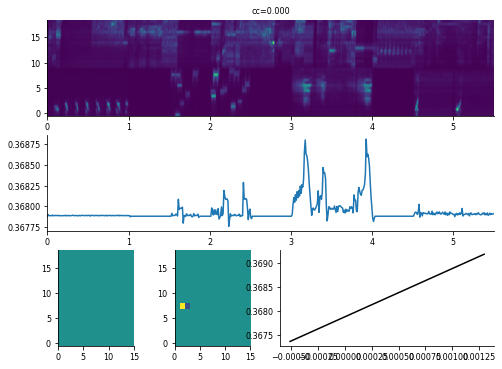

In [5]:
model = Model.from_keywords(modelspec)

wc = model.layers[0]['coefficients'].values
wc[:]=0
wc[7,1,1]=1
model.layers[0]['coefficients'] = wc

fir = model.layers[1]['coefficients'].values
fir[:]=0
fir[1,1,1]=0.5
fir[2,1,1]=-0.25
model.layers[1]['coefficients'] = fir

wc2 = model.layers[2]['coefficients'].values
wc2[0] = 1
model.layers[2]['coefficients'] = wc2

#print(model.layers[3]['shift'].values, model.layers[3]['offset'].values, model.layers[3]['gain'].values)

plot_binaural_model(model, X_val, Y_val=None)
#plot_binaural_layers(model, X_val, Y_val=None)